In [1]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
import torch.nn as nn
import torch.optim as optim
from PIL import Image
import matplotlib.pyplot as plt
from pathlib import Path
import torchvision  # Импортируем torchvision для make_grid и других утилит
import torchvision.utils as vutils  # Импортируем utils для make_grid


# Указываем путь к вашему набору данных
data_dir = 'data/images/'
annotations_dir = 'data/annotations/'

# Считываем аннотации
with open(os.path.join(annotations_dir, 'trainval.txt'), 'r') as f:
    train_files = f.read().splitlines()

with open(os.path.join(annotations_dir, 'test.txt'), 'r') as f:
    test_files = f.read().splitlines()

# Функция очистки имени файла
def clean_filename(file_name):
    return file_name.replace(" ", "_")

class OxfordPetsDataset(Dataset):
    def __init__(self, files, data_dir, transform=None):
        self.files = files  # Список имен файлов без расширений
        self.data_dir = data_dir  # Путь к директории с изображениями
        self.transform = transform  # Трансформации для изображений
        self.class_to_idx = {'cat': 0, 'dog': 1}  # Пример классов, если только кошки и собаки
        
    def __len__(self):
        return len(self.files)  # Длина набора данных
    
    def __getitem__(self, idx):
        file_name = self.files[idx]
        
        # Обрезаем все, что идет после первого пробела (например, "pomeranian_141 25 2 17.jpg" -> "pomeranian_141.jpg")
        file_name = file_name.split(' ')[0]  # Разделяем по пробелу и берем только первую часть
        file_name += '.jpg'  # Добавляем расширение .jpg
        
        # Формируем полный путь к изображению
        img_path = os.path.join(self.data_dir, file_name)
        
        # Печатаем путь для отладки
        print(f"Attempting to load: {img_path}")
        
        try:
            img = Image.open(img_path)  # Открываем изображение
            # Преобразуем в формат RGB, если это необходимо (например, если изображение RGBA)
            img = img.convert('RGB')  # Это гарантирует, что изображение будет в формате RGB
        except FileNotFoundError:
            print(f"File not found: {img_path}")  # Если не удалось найти файл
            raise
        
        # Определяем метку класса из имени файла (например, "cat" или "dog")
        label = 0 if 'cat' in file_name else 1  # Пример метки
        
        # Применяем трансформации (если они заданы)
        if self.transform:
            img = self.transform(img)
        
        return img, label

# Пример трансформаций
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Изменяем размер на 224x224
    transforms.ToTensor(),  # Преобразуем изображение в тензор
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Нормализация для ImageNet
])

# Создаем объекты Dataset для train и test
train_dataset = OxfordPetsDataset(files=train_files, data_dir=data_dir, transform=transform)
test_dataset = OxfordPetsDataset(files=test_files, data_dir=data_dir, transform=transform)

# Создание загрузчиков данных
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Загрузка модели ResNet-18
model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
model.fc = nn.Linear(model.fc.in_features, 2)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Определение потерь и оптимизатора
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Обучение модели
num_epochs = 2
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}, Accuracy: {100 * correct / total:.2f}%")

# Оценка модели
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Test Accuracy: {100 * correct / total:.2f}%")

Attempting to load: data/images/Ragdoll_136.jpg
Attempting to load: data/images/pug_179.jpg
Attempting to load: data/images/staffordshire_bull_terrier_152.jpg
Attempting to load: data/images/British_Shorthair_123.jpg
Attempting to load: data/images/saint_bernard_187.jpg
Attempting to load: data/images/Persian_10.jpg
Attempting to load: data/images/saint_bernard_153.jpg
Attempting to load: data/images/Maine_Coon_204.jpg
Attempting to load: data/images/american_pit_bull_terrier_167.jpg
Attempting to load: data/images/Russian_Blue_181.jpg
Attempting to load: data/images/german_shorthaired_169.jpg
Attempting to load: data/images/samoyed_107.jpg
Attempting to load: data/images/Sphynx_128.jpg
Attempting to load: data/images/havanese_13.jpg
Attempting to load: data/images/saint_bernard_158.jpg
Attempting to load: data/images/Sphynx_182.jpg
Attempting to load: data/images/yorkshire_terrier_160.jpg
Attempting to load: data/images/Russian_Blue_194.jpg
Attempting to load: data/images/Russian_Blue

Attempting to load: data/images/Abyssinian_201.jpg
Attempting to load: data/images/Abyssinian_202.jpg
Attempting to load: data/images/Abyssinian_204.jpg
Attempting to load: data/images/Abyssinian_205.jpg
Attempting to load: data/images/Abyssinian_206.jpg
Attempting to load: data/images/Abyssinian_207.jpg
Attempting to load: data/images/Abyssinian_20.jpg
Attempting to load: data/images/Abyssinian_210.jpg
Attempting to load: data/images/Abyssinian_212.jpg
Attempting to load: data/images/Abyssinian_213.jpg
Attempting to load: data/images/Abyssinian_215.jpg
Attempting to load: data/images/Abyssinian_216.jpg
Attempting to load: data/images/Abyssinian_217.jpg
Attempting to load: data/images/Abyssinian_219.jpg
Attempting to load: data/images/Abyssinian_21.jpg
Attempting to load: data/images/Abyssinian_220.jpg
Attempting to load: data/images/Abyssinian_221.jpg
Attempting to load: data/images/Abyssinian_223.jpg
Attempting to load: data/images/Abyssinian_224.jpg
Attempting to load: data/images/A

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


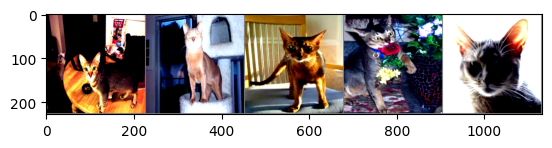

Labels: tensor([1, 1, 1, 1, 1])
Predicted: tensor([1, 1, 1, 1, 1])


In [2]:
import numpy as np
# Функция для отображения изображений
def imshow(img):
    # Денормализация изображения (если использовалась нормализация)
    img = img / 2 + 0.5  # Обратная нормализация
    np_img = img.numpy()  # Преобразуем тензор в numpy массив
    np_img = np.transpose(np_img, (1, 2, 0))  # Меняем порядок осей с (C, H, W) на (H, W, C)
    plt.imshow(np_img)  # Показываем изображение
    plt.show()

# Преобразуем DataLoader в итератор
dataiter = iter(test_loader)

# Получаем следующий батч (изображения и метки)
images, labels = next(dataiter)

# Переносим изображения и метки на нужное устройство (например, на GPU, если доступно)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
images, labels = images.to(device), labels.to(device)

# Покажем первые 5 изображений и их предсказания
imshow(vutils.make_grid(images[:5]))  # Используем make_grid из vutils

# Получаем предсказания модели
outputs = model(images)  # Получаем предсказания для изображений
_, predicted = torch.max(outputs, 1)  # Получаем классы с максимальной вероятностью

# Печатаем метки и предсказания
print(f"Labels: {labels[:5]}")
print(f"Predicted: {predicted[:5]}")

In [3]:
# Функция для распознавания изображения
def predict_image(image_path, model, transform, class_names):
    img = Image.open(image_path)
    img_tensor = transform(img).unsqueeze(0)  # Добавляем размерность для батча

    # Используем GPU, если доступен
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    img_tensor = img_tensor.to(device)

    # Прогоняем изображение через модель
    model.eval()
    with torch.no_grad():
        outputs = model(img_tensor)
    
    # Получаем класс с максимальной вероятностью
    _, predicted_class = torch.max(outputs, 1)

    # Возвращаем класс и метку
    return class_names[predicted_class.item()]

# Нужно вручную создать список классов
class_names = ['Abyssinian', 'Basset_Hound', 'Beagle', 'Bengal', 'Birman', 'Bombay', 'British_Shorthair', 'Chihuahua', 'Egyptian_Mau', 'Havanese', 'Javanese', 'Korat', 'Maine_Coon', 'Manx', 'Munchkin', 'Norwegian_Forest_Cat', 'Persian', 'Ragdoll', 'Russian_Blue', 'Siamese', 'Sphynx', 'Yorkshire_Terrier']

image_path = 'data/train/dog/dog2.jpg'  # Путь к изображению для предсказания
predicted_label = predict_image(image_path, model, transform, class_names)
print(f"Предсказанный класс: {predicted_label}")


Предсказанный класс: Basset_Hound
